# Introduction

Usually, crypto seasons count from the highest and lowest price of a cycle, but what if we will take more stable anchor points - halvings. Halvings are the most important BTC on-chain events. It happens every 210,000 blocks, but the speed of block mining changes over time and it is not so stable, that is why even the duration between halvings is not the same. What if we will replace the standard time-axis and will count blocks, not time? In this case, we will get precise seasons depending on blocks and next, we can try to extract some seasonality from price moving history.

*Data taken from tradingview*

# EDA

Installing packages

In [1]:
!pip install tslearn

## Importing libraries

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import adfuller
from tslearn.barycenters import softdtw_barycenter
from tslearn.barycenters import softdtw_barycenter
import matplotlib.pyplot as plt
from scipy import stats
import os

## Importing data

In [3]:
BASE_DIR = os.getcwd()

In [4]:
# INDEX_BTCUSD, 720 - 12h timefame
df = pd.read_csv(f'{BASE_DIR}/datasets/BTC-USD(4).csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    4846 non-null   object 
 1   open    4846 non-null   float64
 2   high    4846 non-null   float64
 3   low     4846 non-null   float64
 4   close   4846 non-null   float64
dtypes: float64(4), object(1)
memory usage: 189.4+ KB


In [5]:
blocks = pd.read_csv(f'{BASE_DIR}/datasets/GLASSNODE_BTC_BLOCKS, 1D.csv')
blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5212 entries, 0 to 5211
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    5212 non-null   object
 1   open    5212 non-null   int64 
 2   high    5212 non-null   int64 
 3   low     5212 non-null   int64 
 4   close   5212 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 203.7+ KB


## Preparing data

Convert the `time` column to proper type and set it as index.

In [6]:
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(df['time']).drop('time', axis=1)

We will use only `close`, lets remove other components of candle.

In [7]:
df = df.drop(['open','high','low'], axis=1)
df = df.astype('float')

In [8]:
df_d = df[['close']]

Lets have a look on what we have.

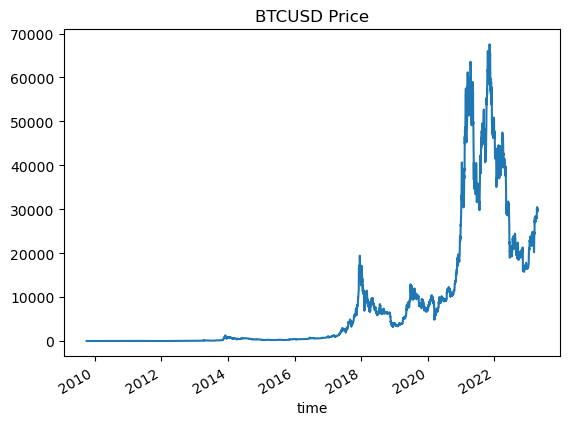

In [9]:
df_d['close'].plot(kind='line', title='BTCUSD Price');

## Replace indexes

Removing useless columns

In [10]:
blocks['time'] = pd.to_datetime(blocks['time'])
blocks = blocks.set_index(blocks['time']).drop('time', axis=1)
blocks = blocks.drop(['open','high','low'], axis=1)
blocks = blocks.astype('float')
blocks['close2'] = blocks['close']
blocks = blocks.drop(['close'], axis=1)

Joining price and ammount of mined blocks by time.

In [11]:
df_b =df.join(blocks, how='inner')
df_b.rename(columns={'close2': 'block'}, inplace=True)
df_b

,close,block
time,,
2009-10-05 00:00:00+00:00,0.000764,24418.0
2009-10-06 00:00:00+00:00,0.000885,24461.0
2009-10-07 00:00:00+00:00,0.001050,24521.0
2009-10-08 00:00:00+00:00,0.001084,24591.0
2009-10-09 00:00:00+00:00,0.001200,24671.0
...,...,...
2023-04-13 00:00:00+00:00,30407.470000,785290.0
2023-04-14 00:00:00+00:00,30495.030000,785430.0
2023-04-15 00:00:00+00:00,30324.640000,785588.0


Lets look at changing of speed of mining over the time.

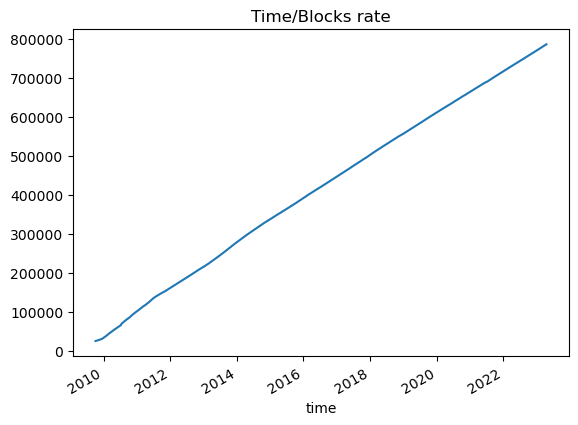

In [12]:
df_b['block'].plot(kind='line', title='Time/Blocks rate');

And finally, replacing of time-indexing to block-indexing.

In [13]:
df_b

,close,block
time,,
2009-10-05 00:00:00+00:00,0.000764,24418.0
2009-10-06 00:00:00+00:00,0.000885,24461.0
2009-10-07 00:00:00+00:00,0.001050,24521.0
2009-10-08 00:00:00+00:00,0.001084,24591.0
2009-10-09 00:00:00+00:00,0.001200,24671.0
...,...,...
2023-04-13 00:00:00+00:00,30407.470000,785290.0
2023-04-14 00:00:00+00:00,30495.030000,785430.0
2023-04-15 00:00:00+00:00,30324.640000,785588.0


In [14]:
df_b.set_index('block', inplace=True)

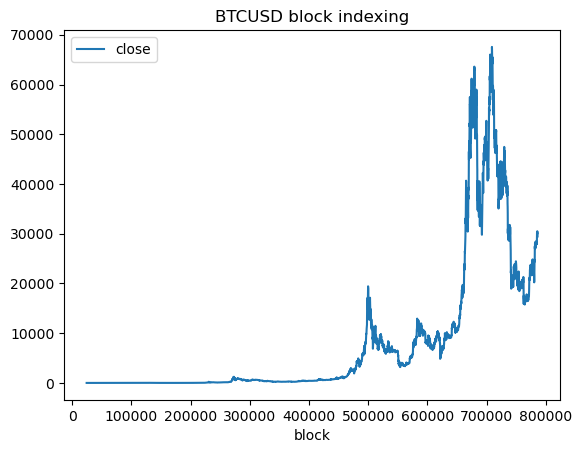

In [15]:
df_b.plot(kind='line', title='BTCUSD block indexing');

In [16]:
df_b

,close
block,
24418.0,0.000764
24461.0,0.000885
24521.0,0.001050
24591.0,0.001084
24671.0,0.001200
...,...
785290.0,30407.470000
785430.0,30495.030000
785588.0,30324.640000


## Box-Cox Transformation

In [17]:
df_box = pd.DataFrame(df_b.copy())
df_box['close'], box_cox_lambda = stats.boxcox(df_b['close'])

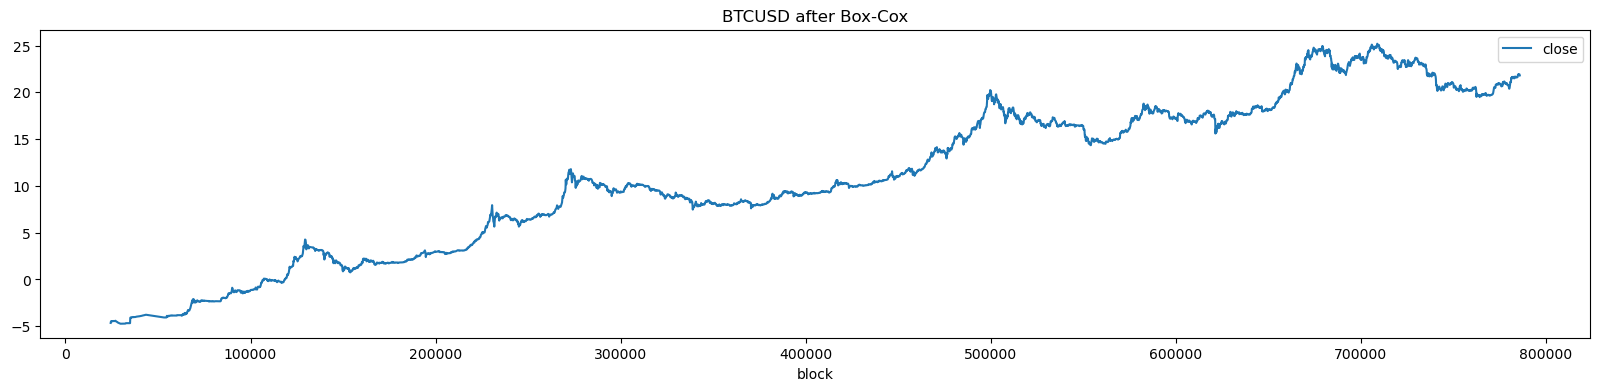

In [18]:
df_box.plot(kind='line', figsize = (20,4), title='BTCUSD after Box-Cox');

In [19]:
box_cox_lambda

0.13134561458013058

## LOWESS (Locally Weighted Scatterplot Smoothing)

LOWESS allows manually extract trend and subtrack it from time series.

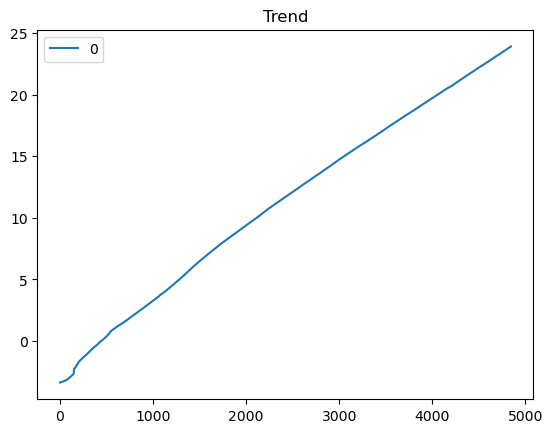

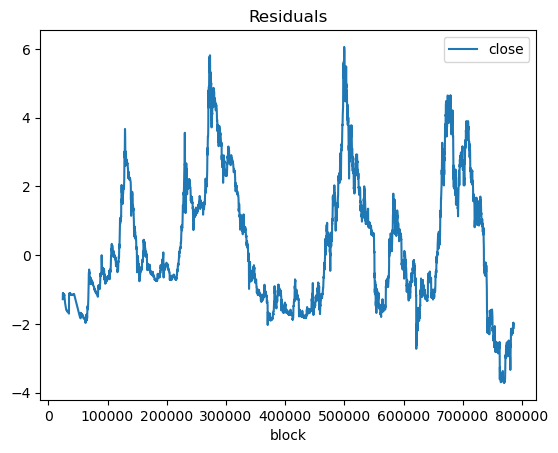

In [20]:
trend = pd.DataFrame(lowess(df_box['close'], df_box.index, frac=1, it=4, return_sorted=False))
trend.plot(kind='line', title='Trend');
trend.set_index(df_box.index, inplace=True)
df_cycle = df_box.copy()
df_cycle['close'] = (df_box['close'] - trend[0])
df_cycle.plot(kind='line', title='Residuals');

Lets check residuals using ADF test.

In [21]:
result = adfuller(df_box)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.5885636163616288
p-value: 0.4893358153424497
Critical Values: {'1%': -3.4317096824174698, '5%': -2.862140827434085, '10%': -2.5670898220592187}


The test is passed.

## Filling missing values and resamling

Due to the transition from time-indexing to block-indexing, two issues have appear:  

1. There are many missing values at the beginning of the dataset because block count information is missing in beginning of BTC history. To fill these gaps we will use the `bfill` method.  

2. Since mining speed is non-linearly dependent on time, the resulting index is non-monotonic. The most simple way is just resample time series.

Currently, the history counts 210,000 * 3 + 155,867 blocks.
Some information is missing at the beginning, and some blocks are missing at the end of the last cycle because it has not yet completed.
To make the series monotonic, we will group the data into larger periods, with each indexing step being equal to 1000 blocks.

In [22]:
print(f'Will divide data to {round((210000*3 + 155867)/100)} bins')

Will divide data to 7859 bins


Trim the data to a length that can be divided by 100 without a remainder.

In [23]:
df_cycle = df_cycle[0:785900]

Fill gaps after detrend a series.

In [24]:
new_row = pd.DataFrame({'close': [None], 'time': [0.0]})
new_row = new_row.set_index('time', drop=True)

df_cycle = pd.concat([new_row, df_cycle], axis=0)


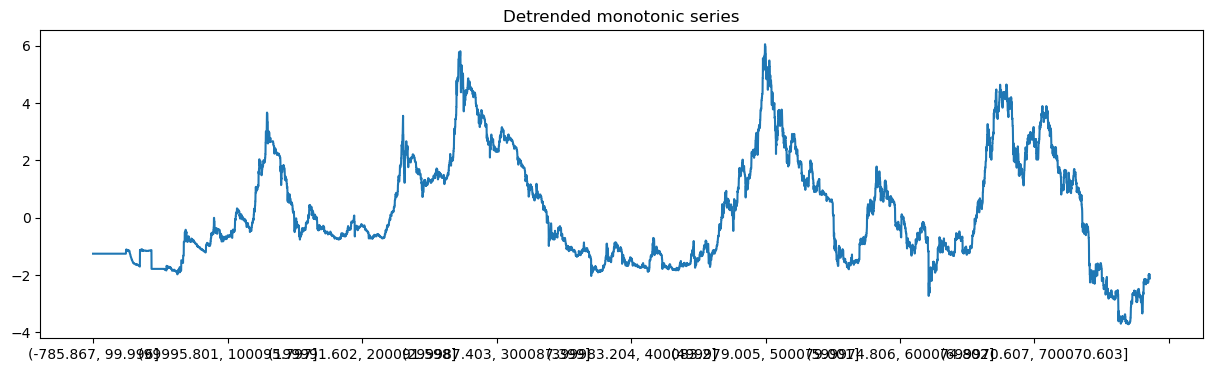

In [25]:
# Divide the data into batches
batches = pd.cut(df_cycle.index, bins=round((785900)/100))

# Grouping values using a mean method
grouped = df_cycle.groupby(batches)['close'].mean()

# Fill 'na' values
grouped = grouped.fillna(method='bfill')
grouped.plot(kind='line', figsize = (15,4), title='Detrended monotonic series');

After we have make series monotonic we can drop indexes.

In [26]:
df_g = grouped.reset_index(drop=True)
df_g

0      -1.252094
1      -1.252094
2      -1.252094
3      -1.252094
4      -1.252094
          ...   
7854   -1.962241
7855   -1.989343
7856   -1.989343
7857   -1.993430
7858   -2.112057
Name: close, Length: 7859, dtype: float64

## Extraction of a period

First of all we must divide timeseries by every halving (210000 blocks).

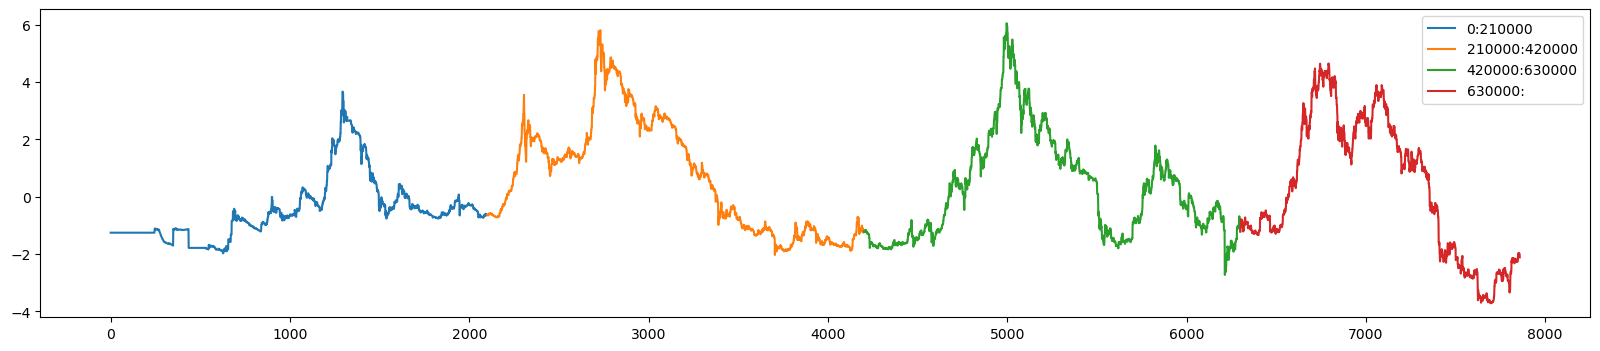

In [27]:
fig, ax = plt.subplots()

df_g[0:2100].plot(kind='line', ax=ax, figsize = (20,4))
df_g[2100:4200].plot(kind='line', ax=ax, figsize = (20,4))
df_g[4200:6300].plot(kind='line', ax=ax, figsize = (20,4))
df_g[6300:].plot(kind='line', ax=ax, figsize = (20,4))

ax.legend(['0:210000', '210000:420000', '420000:630000', '630000:'])
plt.show()


We see 4 periods with a pretty similar structure. Lets have a look to few averaging methods.

For averaging of periods we need do some additional steps.

In [28]:
df_t1 = df_g[0:2100]
df_t1.index = df_t1.index
df_t2 = df_g[2100:4200]
df_t2.index = df_t2.index - 2100
df_t3 = df_g[4200:6300]
df_t3.index = df_t3.index - 4200
df_t4 = df_g[6300:]
df_t4.index = df_t4.index - 6300

In [29]:
df_all = pd.DataFrame(df_t1.copy())
# Dividing weight of first period in a half to decrease it impact to resulting pattern.
df_all['close'] = df_all['close']/2
df_all['close2'] = df_t2
df_all['close3'] = df_t3
df_all['close4'] = df_t4

In [30]:
df_all

,close,close2,close3,close4
0,-0.626047,-0.635795,-1.214298,-1.210226
1,-0.626047,-0.630518,-1.228192,-1.119947
2,-0.626047,-0.630518,-1.228192,-0.944026
3,-0.626047,-0.622380,-1.232683,-0.944026
4,-0.626047,-0.628958,-1.181498,-0.782569
...,...,...,...,...
2095,-0.301442,-1.115117,-0.748354,NaN
2096,-0.317693,-1.115117,-0.844603,NaN
2097,-0.317693,-1.250994,-0.844603,NaN
2098,-0.323044,-1.161726,-1.146170,NaN


Filling missing values of last period using `ffill`.

In [31]:
df_mean = df_all.fillna(method='ffill').mean(axis=1)

### Averaging

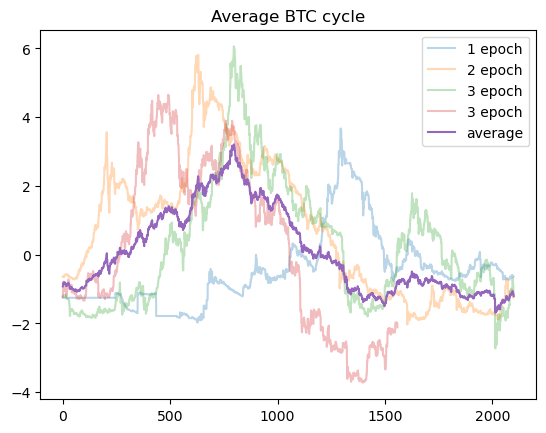

In [32]:
fig, ax = plt.subplots()

df_t1.plot(kind='line', ax=ax, alpha = 0.3)
df_t2.plot(kind='line', ax=ax, alpha = 0.3)
df_t3.plot(kind='line', ax=ax, alpha = 0.3)
df_t4.plot(kind='line', ax=ax, alpha = 0.3)
df_mean.plot(kind='line', ax=ax)

ax.legend(['1 epoch', '2 epoch', '3 epoch', '3 epoch','average'])
plt.title('Average BTC cycle')
plt.show()


### DTW (Dynamic Time Wraping)

This method allows to get an "average" period regardless biases of a time-series.

In [33]:
df_full = df_all.fillna(method='ffill')

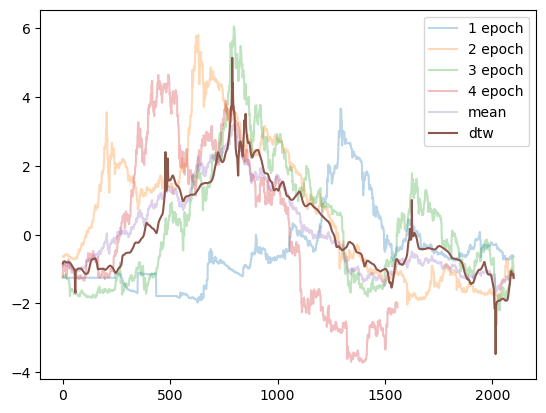

In [34]:
dtw = softdtw_barycenter(df_full.transpose(), gamma=1, max_iter=500, tol=1e-4)
df_dtw = pd.DataFrame(dtw)

fig, ax = plt.subplots()

df_t1.plot(kind='line', ax=ax, alpha = 0.3)
df_t2.plot(kind='line', ax=ax, alpha = 0.3)
df_t3.plot(kind='line', ax=ax, alpha = 0.3)
df_t4.plot(kind='line', ax=ax, alpha = 0.3)
df_mean.plot(kind='line', ax=ax, alpha = 0.3)
df_dtw.plot(kind='line', ax=ax)

ax.legend([
    '1 epoch', 
    '2 epoch', 
    '3 epoch', 
    '4 epoch', 
    'mean',
    'dtw',
])

plt.show()


### DTW weighted

This method allows to add weights to initial periods. Lets divide first period by 2.

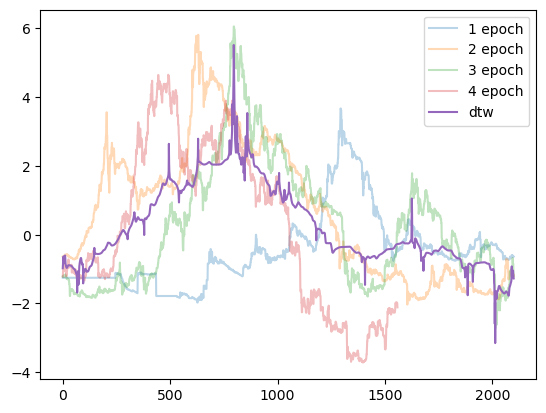

In [44]:
dtw = (softdtw_barycenter(df_full.transpose(), weights=[0.5,1,1,1], gamma=0.1, max_iter=500, tol=1e-4))
df_dtw = pd.DataFrame(dtw)

fig, ax = plt.subplots()

df_t1.plot(kind='line', ax=ax, alpha = 0.3)
df_t2.plot(kind='line', ax=ax, alpha = 0.3)
df_t3.plot(kind='line', ax=ax, alpha = 0.3)
df_t4.plot(kind='line', ax=ax, alpha = 0.3)
df_dtw.plot(kind='line', ax=ax)

ax.legend([
    '1 epoch', 
    '2 epoch', 
    '3 epoch', 
    '4 epoch', 
    'dtw',
    'average',
])

plt.show()

Both DTW methods look strange; they handle peak values much better, but if we use them for forecasting, it will lead to large errors. That's why I will use the simple averaging method. Although it may not be as precise when it comes to peak values, but it shows trends more clearly.

Продублируем циклы и вычтем из временного ряда с детрендом

In [37]:
df_mean_full = np.tile(df_mean, 4)

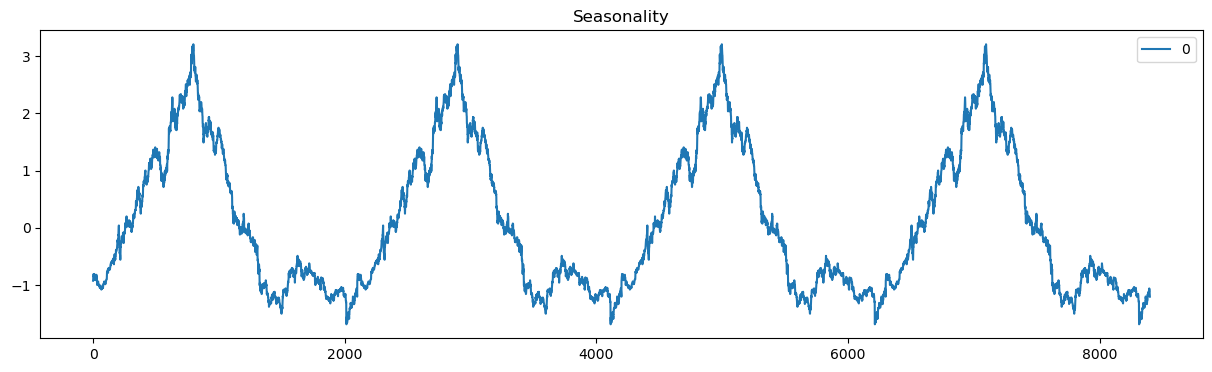

In [38]:
df_mean_full = pd.DataFrame(df_mean_full)[:785000]
df_mean_full.plot(kind = 'line', figsize = (15,4), title='Seasonality');

Lets subtract seasonality and check residuals for stationarity.

In [39]:
df_mean_full = df_mean_full.rename(columns={0: 'close'})

In [40]:
df_residual = pd.DataFrame(df_g) - df_mean_full
df_residual = df_residual.dropna()

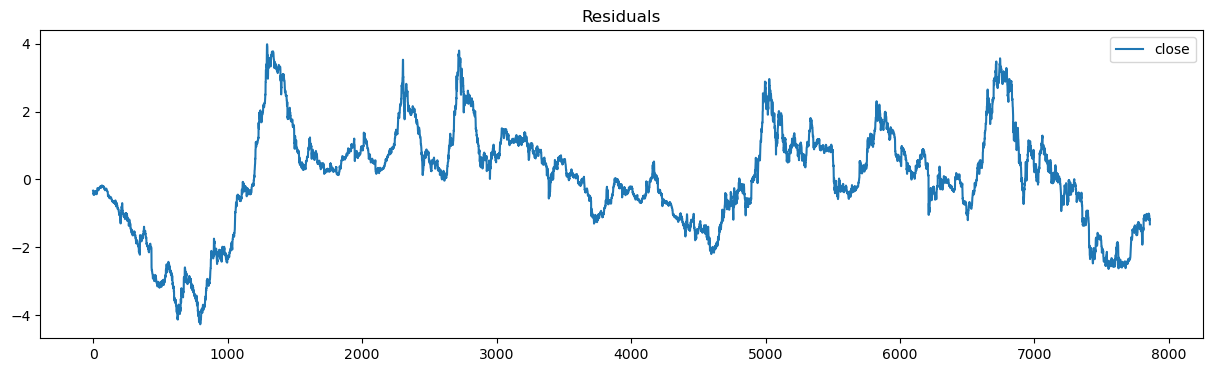

In [41]:
df_residual.plot(kind='line', figsize = (15,4), title='Residuals');

In [42]:
result = adfuller(df_residual)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.5680793286028805
p-value: 0.09977570320167045
Critical Values: {'1%': -3.4311844741213426, '5%': -2.8619087767280904, '10%': -2.5669662952336423}


Based on the results of the Dickey-Fuller test, it can be concluded that there is sufficient statistical significance to reject the null hypothesis of non-stationarity of the series. Therefore the series is stationary.

# Inverse transformation

Rescale back to blocks (786 * 1000)
Add trend
Box-Cox